## 问题定义

本问题为求解2D Helmholtz方程。其形式可以参考案例18中的PDE定义。


### 求解目标

要求求解给定区域内的Helmholtz方程

## NTK

参考论文：Wang, S., Yu, X. and Perdikaris, P., 2022. When and why PINNs fail to train: A neural tangent kernel perspective. Journal of Computational Physics, 449, p.110768.

基于NTK分析的自动损失权重。

假设具有如下形式的损失函数：

![equation](./resource/equation.png)

则其NTK定义为各项雅可比矩阵的函数：

![ntk](./resource/ntk.png)

其中$J_r$和$J_b$分别为$\mathcal{L}_r$和$\mathcal{L}_b$的雅可比矩阵

基于上述的参考论文，有如下的损失权重定义

![loss weights](./resource/loss_weight.png)

上述定义的核心逻辑在于：对于每一个损失项，其收敛速度可以由其对应NTK的特征值反映。因此能够通过NTK进行配平，从而使得各损失项有基本相同的收敛速度。

## 求解

In [1]:
import os
import warnings

# optional
# set appropriate GPU in case of multi-GPU machine
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.utils import compose
from modulus.sym.utils.io.plotter import ValidatorPlotter, InferencerPlotter

In [3]:
from sympy import Symbol, pi, sin

import modulus.sym
from modulus.sym.hydra import to_absolute_path, instantiate_arch, ModulusConfig
from modulus.sym.utils.io import csv_to_dict
from modulus.sym.solver import Solver
from modulus.sym.domain import Domain
from modulus.sym.geometry.primitives_2d import Rectangle
from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
from modulus.sym.domain.validator import PointwiseValidator
from modulus.sym.domain.inferencer import PointwiseInferencer
from modulus.sym.key import Key
from modulus.sym.node import Node
from modulus.sym.eq.pdes.wave_equation import HelmholtzEquation
from modulus.sym.utils.io.plotter import ValidatorPlotter

In [4]:
cfg = compose(config_path="conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

/usr/local/lib/python3.10/dist-packages/modulus/sym/hydra/utils.py:148: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(


training:
  max_steps: 20000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: ${training.rec_results_freq}
  rec_inference_freq: ${training.rec_results_freq}
  rec_monitor_freq: ${training.rec_results_freq}
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: true
    save_name: ntk
    run_freq: 10
graph:
  func_arch: false
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk,npz
summary_histograms: false
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: false
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch:
  

### 定义必要组件

#### Geo

In [5]:
x, y = Symbol("x"), Symbol("y")
height = 2
width = 2
rec = Rectangle((-width / 2, -height / 2), (width / 2, height / 2))

#### PDE

In [6]:
wave = HelmholtzEquation(u="u", k=1.0, dim=2)  # 亥姆霍兹方程

#### Model

In [7]:
# 定义简单的全连接网络
# 输入为空间坐标和
# 输出为E_z(x, y)
wave_net = instantiate_arch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u")],
    cfg=cfg.arch.fully_connected,
)

#### Node

In [8]:
nodes = wave.make_nodes() + [wave_net.make_node(name="wave_network")]

#### Domain

In [9]:
domain = Domain()

#### ABC边界

In [10]:
wall = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"u": 0},
    batch_size=cfg.batch_size.wall,
    lambda_weighting={"u": 1.0},
)
domain.add_constraint(wall, "wall")

#### PDE约束

In [11]:
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={
        "helmholtz": -(
            -((pi) ** 2) * sin(pi * x) * sin(4 * pi * y)
            - ((4 * pi) ** 2) * sin(pi * x) * sin(4 * pi * y)
            + 1 * sin(pi * x) * sin(4 * pi * y)
        )
    },
    batch_size=cfg.batch_size.interior,
    bounds={x: (-width / 2, width / 2), y: (-height / 2, height / 2)},
    lambda_weighting={
        "helmholtz": 1.0,
    },
)
domain.add_constraint(interior, "interior")

#### 验证器以及其他必要组件

In [12]:
file_path = "openfoam/helmholtz.csv"
if os.path.exists(to_absolute_path(file_path)):
    mapping = {"x": "x", "y": "y", "z": "u"}
    openfoam_var = csv_to_dict(to_absolute_path(file_path), mapping)
    openfoam_invar_numpy = {
        key: value for key, value in openfoam_var.items() if key in ["x", "y"]
    }
    openfoam_outvar_numpy = {
        key: value for key, value in openfoam_var.items() if key in ["u"]
    }

    openfoam_validator = PointwiseValidator(
        nodes=nodes,
        invar=openfoam_invar_numpy,
        true_outvar=openfoam_outvar_numpy,
        batch_size=1024,
        plotter=ValidatorPlotter(),
    )
    domain.add_validator(openfoam_validator)
else:
    warnings.warn(
        f"Directory {file_path} does not exist. Will skip adding validators. Please download the additional files from NGC https://catalog.ngc.nvidia.com/orgs/nvidia/teams/modulus/resources/modulus_sym_examples_supplemental_materials"
    )

### 求解器以及求解

In [13]:
# 定义求解器
slv = Solver(cfg, domain)

手动加载日志系统

In [14]:
import logging
# logging.getLogger().addHandler(logging.StreamHandler())
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

启动求解

In [15]:
slv.solve()

2024-03-01 14:13:01,889 - WARNING - Installed PyTorch version 2.2.0a0+81ea7a4 is not TorchScript supported in Modulus. Version 2.1.0a0+4136153 is officially supported.
2024-03-01 14:13:01,897 - INFO - attempting to restore from: /workspace/21_2D_Helmholtz_NTK/outputs
2024-03-01 14:13:01,898 - WARNING - optimizer checkpoint not found
2024-03-01 14:13:01,899 - WARNING - model wave_network.0.pth not found
2024-03-01 14:13:03,429 - INFO - [step:          0] record constraint batch time:  1.994e-01s
2024-03-01 14:13:17,257 - INFO - [step:          0] record validators time:  1.383e+01s
2024-03-01 14:13:17,285 - INFO - [step:          0] saved checkpoint to /workspace/21_2D_Helmholtz_NTK/outputs
2024-03-01 14:13:17,287 - INFO - [step:          0] loss:  2.851e+04
2024-03-01 14:13:30,074 - INFO - [step:        100] loss:  1.171e+04, time/iteration:  1.279e+02 ms
2024-03-01 14:13:43,465 - INFO - [step:        200] loss:  7.367e+01, time/iteration:  1.339e+02 ms
2024-03-01 14:13:55,795 - INFO -

2024-03-01 14:24:50,877 - INFO - [step:       6100] loss:  2.993e-01, time/iteration:  8.353e+01 ms
2024-03-01 14:24:58,795 - INFO - [step:       6200] loss:  2.459e-01, time/iteration:  7.915e+01 ms
2024-03-01 14:25:07,285 - INFO - [step:       6300] loss:  2.576e-01, time/iteration:  8.486e+01 ms
2024-03-01 14:25:15,533 - INFO - [step:       6400] loss:  3.428e-01, time/iteration:  8.246e+01 ms
2024-03-01 14:25:23,433 - INFO - [step:       6500] loss:  4.658e+00, time/iteration:  7.898e+01 ms
2024-03-01 14:25:31,447 - INFO - [step:       6600] loss:  2.367e-01, time/iteration:  8.011e+01 ms
2024-03-01 14:25:39,557 - INFO - [step:       6700] loss:  2.827e-01, time/iteration:  8.109e+01 ms
2024-03-01 14:25:47,232 - INFO - [step:       6800] loss:  2.342e-01, time/iteration:  7.672e+01 ms
2024-03-01 14:25:54,807 - INFO - [step:       6900] loss:  2.384e-01, time/iteration:  7.573e+01 ms
2024-03-01 14:26:17,360 - INFO - [step:       7000] record validators time:  1.374e+01s
2024-03-01 1

2024-03-01 14:35:41,072 - INFO - [step:      12900] loss:  2.433e-01, time/iteration:  8.343e+01 ms
2024-03-01 14:36:03,132 - INFO - [step:      13000] record validators time:  1.321e+01s
2024-03-01 14:36:03,215 - INFO - [step:      13000] saved checkpoint to /workspace/21_2D_Helmholtz_NTK/outputs
2024-03-01 14:36:03,216 - INFO - [step:      13000] loss:  1.535e-01, time/iteration:  2.214e+02 ms
2024-03-01 14:36:11,177 - INFO - [step:      13100] loss:  2.052e-01, time/iteration:  7.960e+01 ms
2024-03-01 14:36:19,036 - INFO - [step:      13200] loss:  1.557e-01, time/iteration:  7.856e+01 ms
2024-03-01 14:36:27,450 - INFO - [step:      13300] loss:  1.443e-01, time/iteration:  8.413e+01 ms
2024-03-01 14:36:36,379 - INFO - [step:      13400] loss:  1.578e-01, time/iteration:  8.927e+01 ms
2024-03-01 14:36:45,153 - INFO - [step:      13500] loss:  1.548e-01, time/iteration:  8.771e+01 ms
2024-03-01 14:36:53,903 - INFO - [step:      13600] loss:  1.673e-01, time/iteration:  8.748e+01 ms
2

2024-03-01 14:46:50,496 - INFO - [step:      19500] loss:  8.339e-02, time/iteration:  8.726e+01 ms
2024-03-01 14:46:59,605 - INFO - [step:      19600] loss:  8.154e-02, time/iteration:  9.108e+01 ms
2024-03-01 14:47:08,208 - INFO - [step:      19700] loss:  1.127e-01, time/iteration:  8.601e+01 ms
2024-03-01 14:47:17,473 - INFO - [step:      19800] loss:  9.004e-02, time/iteration:  9.264e+01 ms
2024-03-01 14:47:26,129 - INFO - [step:      19900] loss:  8.697e-02, time/iteration:  8.655e+01 ms
2024-03-01 14:47:35,317 - INFO - [step:      20000] record constraint batch time:  8.175e-02s
2024-03-01 14:47:48,075 - INFO - [step:      20000] record validators time:  1.276e+01s
2024-03-01 14:47:48,161 - INFO - [step:      20000] saved checkpoint to /workspace/21_2D_Helmholtz_NTK/outputs
2024-03-01 14:47:48,163 - INFO - [step:      20000] loss:  8.754e-02, time/iteration:  2.203e+02 ms
2024-03-01 14:47:48,163 - INFO - [step:      20000] reached maximum training steps, finished training!


### 后处理以及可视化

对于jupyter，比较方便的方法是使用matplotlib

此外，还可以使用tensorboard以及Paraview

![u](./outputs/validators/validator_u.png)

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
# 读取损失权重数据
ntk_weights_df = pd.read_csv('./ntk.csv')
print(ntk_weights_df.head())

   Unnamed: 0     wall_u  interior_helmholtz
0          10  21.031721            2.045091
1          20  23.458870            3.861664
2          30  45.452484            9.806118
3          40  40.201710           54.964070
4          50  52.444054           92.373800


In [21]:
steps = ntk_weights_df.iloc[:, 0].values
wall_u_weight = ntk_weights_df['wall_u'].values
interior_helmholtz_weight = ntk_weights_df['interior_helmholtz'].values

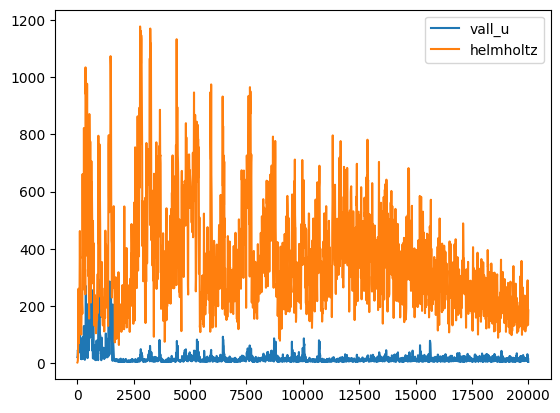

In [24]:
# 绘制损失权重曲线
plt.figure()
plt.plot(steps, wall_u_weight, label='vall_u')
plt.plot(steps, interior_helmholtz_weight, label='helmholtz')
plt.legend()
plt.show()